In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.applications import ResNet50V2


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.utils import plot_model

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Dataset/FER2013/FER2013.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
# define a  function to caculate the number of each emotion classes
train_dir = "/content/train"
test_dir = "/content/test"
def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


**Explanation:** The number of happy faces is about 17 times tha disgust faces in test data set.

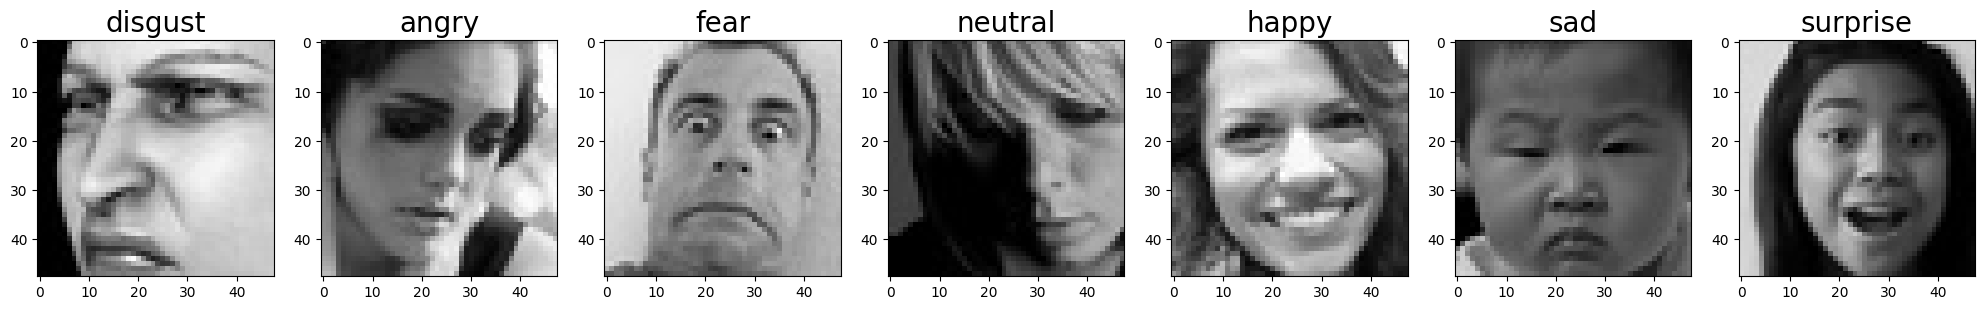

In [ ]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL +'/'+ directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

**Explanation:** Show how the images in the data set look like.

In [ ]:
img_shape = 48
batch_size = 64
train_data_path = "/content/train/"
test_data_path = "/content/test/"


In [ ]:
#using data generators to generate batches of images
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### **CNN Model**

In [ ]:
CNN_Model =model = Sequential()

    #CNN1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

    #CNN2
model.add(Conv2D(64, (3,3), activation='relu', ))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

    #CNN3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))


    #Output
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

### **Specifying CNN Callbacks**

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

### **CNN Training**

In [ ]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=20, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 67s 115ms/step - loss: 2.0424 - accuracy: 0.2105 - val_loss: 1.9157 - val_accuracy: 0.2568 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 47s 105ms/step - loss: 1.7746 - accuracy: 0.2837 - val_loss: 1.7999 - val_accuracy: 0.3050 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 46s 104ms/step - loss: 1.6382 - accuracy: 0.3524 - val_loss: 1.6254 - val_accuracy: 0.3723 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - 46s 104ms/step - loss: 1.4981 - accuracy: 0.4187 - val_loss: 1.5196 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 48s 107ms/step - loss: 1.4113 - accuracy: 0.4588 - val_loss: 1.3306 - val_accuracy: 0.4894 - lr: 0.0010
Epoch 6/20
448/448 [==============================] - 50s 111ms/step - loss: 1.3506 - accuracy: 0.4876 - val_loss: 1.2506 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 7/20
448/448 [==============================] 

### **Evaluating CNN Model**

In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 3s 29ms/step - loss: 0.9765 - accuracy: 0.6319
    Test Loss: 0.97649
Test Accuracy: 63.19%


###   **NN Confusion Matrix**

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

113/113 [==============================] - 3s 26ms/step


In [ ]:
#get the relationship between classes name and numbers
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

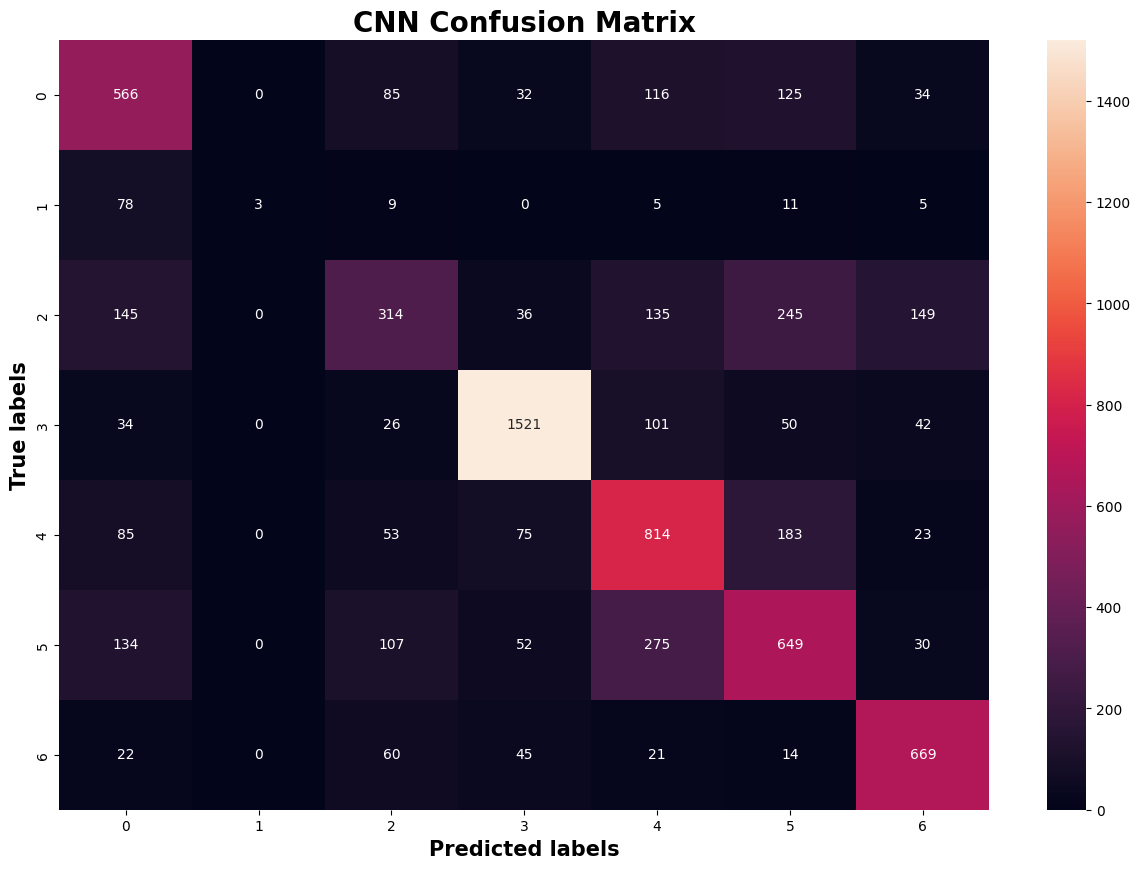

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

### **ResNet50V2 Model**

In [ ]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = "/content/train/"
test_data_path = "/content/test/"

In [ ]:
#load data again
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### **Fine-Tuning ResNet50V2**

In [ ]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

### **Customed Output Layer**

In [ ]:
ResNet50V2_Model = model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_13 (Ba  (None, 64)                256       
 tchNormalization)                                    

In [ ]:
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

### **ResNet Training**

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 20s 180ms/step - loss: 0.8988 - accuracy: 0.6854
    Test Loss: 0.89877
Test Accuracy: 68.54%


### **ResNet Confusion Matrix**

In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 [==============================] - 23s 187ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

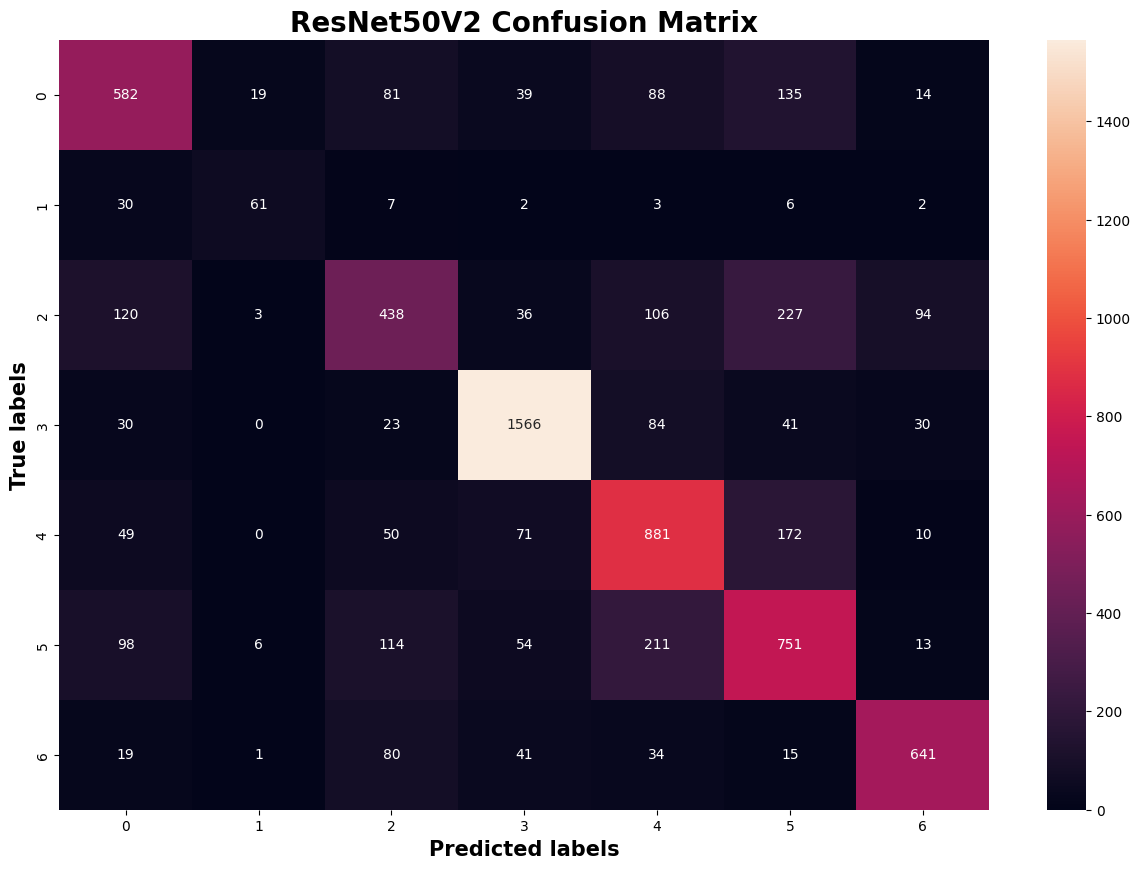

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

### **5Shuffling Test Data**

In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(48,48),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


### **CNN Predictions**

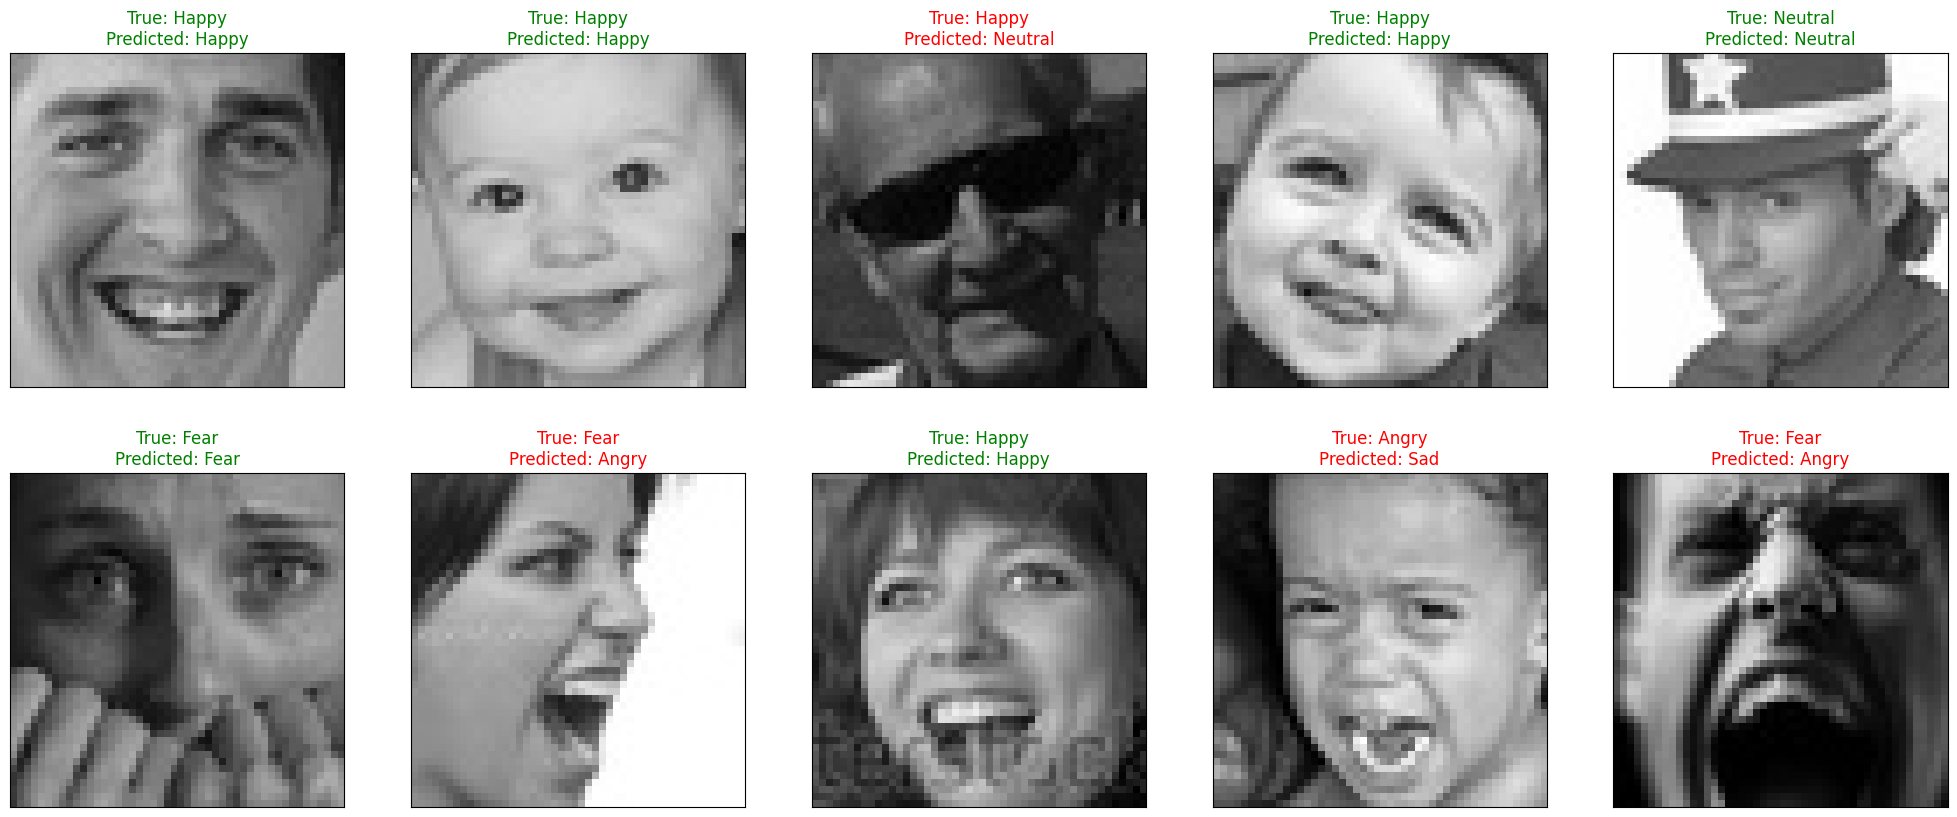

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

### **ResNet50V2 Predictions**

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


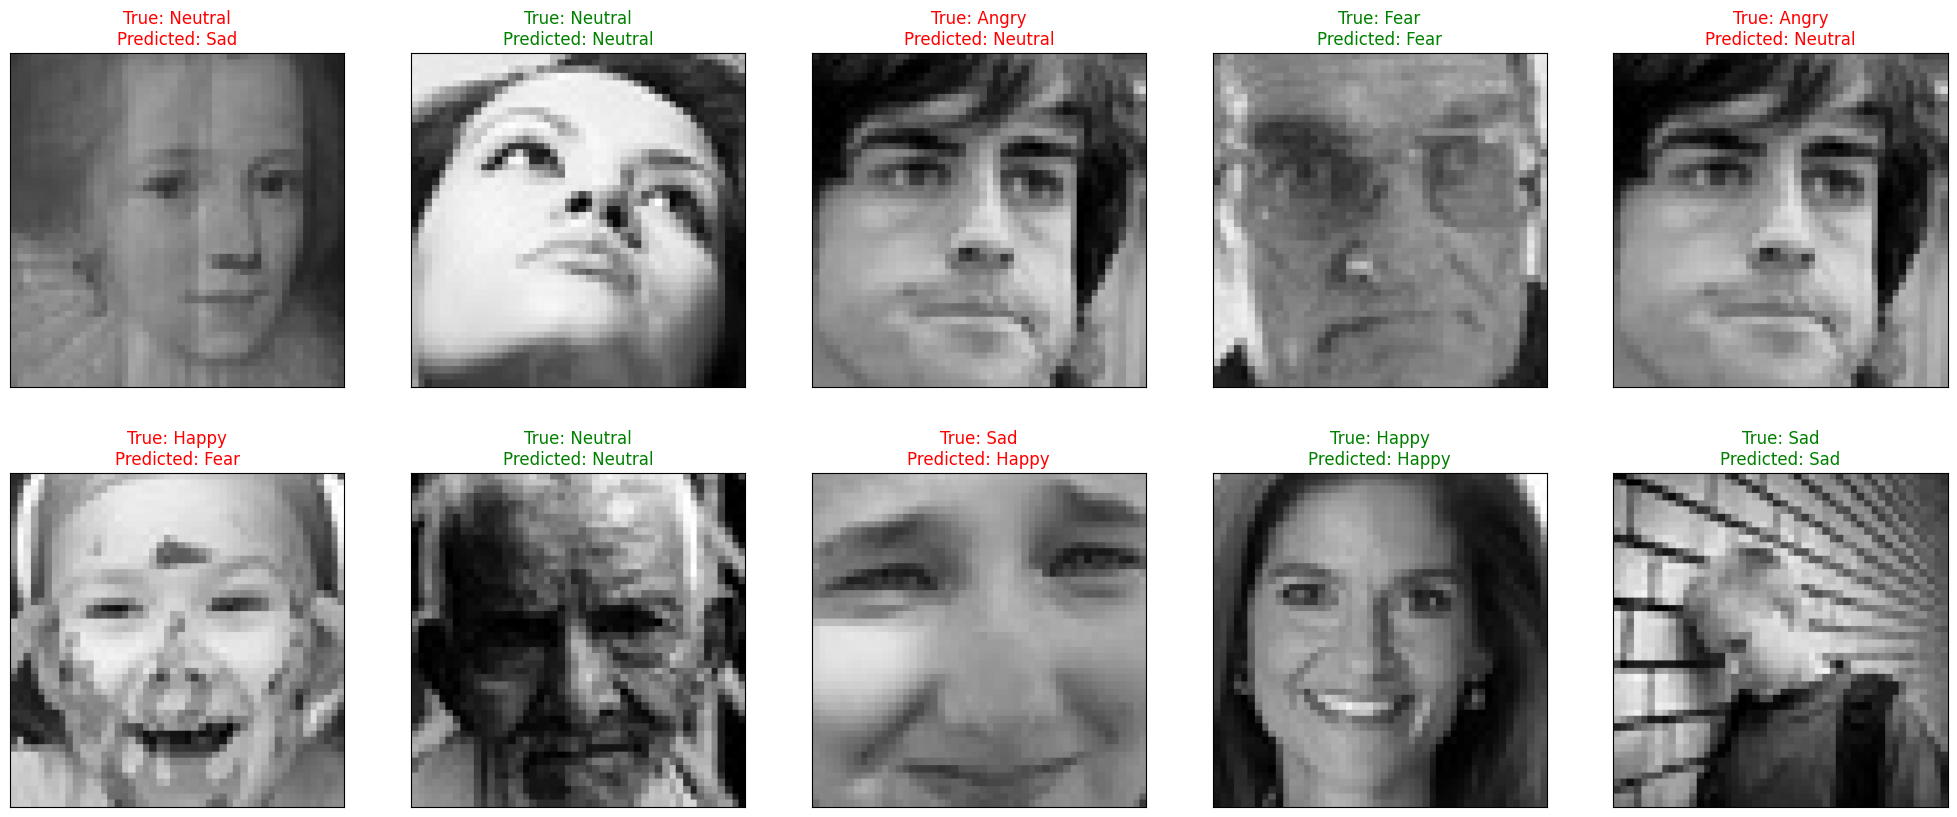

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

## **Save Models**

In [ ]:
CNN_Model.save("CNN_Model.h5")

ResNet50V2_Model.save("ResNet50V2_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)




Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),

                                               weights='imagenet'
                                               )

# # Freezing all layers except last 50

# Freeze all layers except the last one
for layer in ResNet50V2.layers[:-1]:
    layer.trainable = False


ResNet50V2_Model = model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])

ResNet50V2_Model.summary()

base_model = ResNet50V2

intermediate_layer_name = 'conv5_block3_out'
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(intermediate_layer_name).output)


# Get features from intermediate layer for your dataset
features_train = intermediate_layer_model.predict(train_data)
features_test = intermediate_layer_model.predict(test_data)
print(features_train)
print(features_test)

102869336/102869336 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1000)              25613800  
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization (Batch  (None, 1000)              4000      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                

In [ ]:
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(features_train, train_data.labels)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21531, 2, 2, 2048)
(7178, 2, 2, 2048)
(21531,)
(7178,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


def fitness_function(selected_features):
    selected_indices = np.where(selected_features == 1)[0]  # Get indices of selected features

    if len(selected_indices) == 0:
        return 0.0  # Return a low accuracy if no features are selected

    # Reshape data to two dimensions and select specific features
    selected_train = X_train[:, :, :, selected_indices].reshape(X_train.shape[0], -1)
    selected_test = X_test[:, :, :, selected_indices].reshape(X_test.shape[0], -1)

    # Train an SVM classifier using selected features
    clf = SVC(kernel='linear', random_state=42)  # You can try different kernels
    clf.fit(selected_train, y_train)  # Use the labels y_train

    # Evaluate accuracy on test set
    accuracy = clf.score(selected_test, y_test)
    return accuracy



# Define Gray Wolf Optimizer
def gray_wolf_optimizer(fitness_function, num_wolves, num_iterations, num_features):
    # Initialization
    positions = np.random.randint(0, 2, size=(num_wolves, num_features))  # Binary feature selection

    alpha_position = np.zeros(num_features)
    beta_position = np.zeros(num_features)
    delta_position = np.zeros(num_features)
    alpha_score = float('-inf')
    beta_score = float('-inf')
    delta_score = float('-inf')

    for epoch in range(num_iterations):
        for i in range(num_wolves):
            fitness = fitness_function(positions[i])

            if fitness > alpha_score:
                delta_score = beta_score
                delta_position = beta_position.copy()
                beta_score = alpha_score
                beta_position = alpha_position.copy()
                alpha_score = fitness
                alpha_position = positions[i].copy()
            elif fitness > beta_score:
                delta_score = beta_score
                delta_position = beta_position.copy()
                beta_score = fitness
                beta_position = positions[i].copy()
            elif fitness > delta_score:
                delta_score = fitness
                delta_position = positions[i].copy()

        # Update positions based on specific rules (encircling prey)
        for i in range(num_wolves):
            if not np.array_equal(positions[i], alpha_position) and not np.array_equal(positions[i], beta_position) and not np.array_equal(positions[i], delta_position):
                a = 2 * (1 - (epoch / num_iterations))  # Encircling prey coefficient
                r1 = np.random.random()  # Random coefficient
                r2 = np.random.random()  # Random coefficient
                A1 = 2 * r1 * a - a
                C1 = 2 * r2  # Coefficient C1
                D_alpha = abs(C1 * alpha_position - positions[i])  # Distance to Alpha

                updated_position = alpha_position - A1 * D_alpha
                positions[i] = np.clip(updated_position, 0, 1)  # Clip the position between 0 and 1 (for binary selection)

        # Update Alpha, Beta, and Delta positions based on fitness values
        alpha_position = alpha_position  # Update alpha based on your rule
        beta_position = beta_position  # Update beta based on your rule
        delta_position = delta_position  # Update delta based on your rule

    # Return the best position (features) found
    best_position = alpha_position
    return best_position



In [ ]:
num_features = features_train.shape[1]  # Number of features in your last layer
num_wolves = 10
num_iterations = 100

# Apply GWO to select features
best_features = gray_wolf_optimizer(fitness_function, num_wolves, num_iterations, num_features)
print("Selected features:", best_features)
print(best_features.shape)


In [ ]:

best_indices = np.where(best_features == 1)[0]

# Reshape data to two dimensions and select the best features
selected_X_train = X_train[:, :, :, best_indices].reshape(X_train.shape[0], -1)
selected_X_test = X_test[:, :, :, best_indices].reshape(X_test.shape[0], -1)

clf = SVC(kernel='linear', random_state=42)
clf.fit(selected_X_train, y_train)

# Evaluate accuracy on test set
accuracy = clf.score(selected_X_test, y_test)
print("Accuracy with selected features:", accuracy)


In [ ]:
# ResNet50V2_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Extract features using ResNet50V2 base model
# train_features = ResNet50V2_base.predict(train_data)
# test_features = ResNet50V2_base.predict(test_data)


# # Initialize Grey Wolf Optimization
# n_iterations = 100
# n_features = train_features.shape[1]  # Number of features extracted from ResNet50V2
# labels = ...  # Your labels here

# import numpy as np
# from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score


# # Initialize ResNet50V2 model with modified weights
# resnet_model = ResNet50V2(weights='imagenet', include_top=False)
# last_layer = resnet_model.get_layer('conv5_block3_out')


# # Define a function to extract features using modified ResNet50V2 model
# def extract_features(data):
#     features = []
#     labels = []
#     for images, labels_batch in data:
#         intermediate_layer_model = Model(inputs=resnet_model.input, outputs=last_layer.output)

#         intermediate_features = intermediate_layer_model.predict(images)
#         features.extend(intermediate_features)
#         labels.extend(np.argmax(labels_batch, axis=1))

#     return np.array(features), np.array(labels)

In [ ]:
# gwo = GreyWolfOptimizer(n_iterations=n_iterations, n_features=n_features)
# gwo.fit(train_features, labels)  # Fit GWO to select features

# # Select features using GWO
# selected_features = gwo.best_solution


# # Reshape the features to 2D (Flatten the spatial dimensions)
# train_features_flat = train_features.reshape(train_features.shape[0], -1)
# test_features_flat = test_features.reshape(test_features.shape[0], -1)

# # Perform feature selection
# selector = SelectFromModel(ResNet50V2_base, threshold=-np.inf, prefit=True)
# selected_train_features = selector.transform(train_features_flat)
# selected_test_features = selector.transform(test_features_flat)

# # Now, build your model on these selected features
# model = Sequential([
#     Flatten(input_shape=selected_train_features.shape[1:]),  # Input shape matches the selected features
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(7, activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# # Train your model using the selected features
# model_checkpoint = ModelCheckpoint("selected_features_model.h5", monitor="val_accuracy", save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# callbacks = [model_checkpoint, early_stopping, reduce_lr]

# history = model.fit(selected_train_features, train_labels, epochs=20, batch_size=64,
#                     validation_data=(selected_test_features, test_labels),
#                     callbacks=callbacks)

### Genetic algorithm

In [ ]:
# !pip install deap

# from deap import algorithms, base, creator, tools
# ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),

#                                                weights='imagenet'
#                                                )

# # # Freezing all layers except last 50

# # ResNet50V2.trainable = True

# # for layer in ResNet50V2.layers[:-50]:
# #     layer.trainable = False

# # ResNet50V2_Model = model = Sequential([
# #                       ResNet50V2,
# #                       Dropout(.25),
# #                       BatchNormalization(),
# #                       Flatten(),
# #                       Dense(64, activation='relu'),
# #                       BatchNormalization(),
# #                       Dropout(.5),
# #                       Dense(7,activation='softmax')
# #                     ])

# # ResNet50V2_Model.summary()

# base_model = ResNet50V2

# intermediate_layer_name = 'conv5_block3_out'
# intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(intermediate_layer_name).output)


# # Get features from intermediate layer for your dataset
# features_train = intermediate_layer_model.predict(train_data)
# features_test = intermediate_layer_model.predict(test_data)
# print(features_train)
# print(features_test)

In [ ]:
# from sklearn.model_selection import train_test_split
# # from sklearn.ensemble import RandomForestClassifier
# import numpy as np


# X_train, X_test, y_train, y_test = train_test_split(features_train, train_data.labels)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [ ]:
# def initialize_population(num_individuals, num_features):
#     return np.random.choice([0, 1], size=(num_individuals, num_features))

# def fitness(features):
#     if np.sum(features) == 0:
#         return 0  # Return zero accuracy if no features are selected

#     clf = SVC(kernel='linear', random_state=42)

#     # Reshape features to 2D array before fitting into SVM
#     X_train_selected = X_train[:, features == 1].reshape(X_train.shape[0], -1)
#     X_test_selected = X_test[:, features == 1].reshape(X_test.shape[0], -1)

#     clf.fit(X_train_selected, y_train)
#     return clf.score(X_test_selected, y_test)

# def selection(population, scores, num_to_select):
#     selected_indices = np.argsort(scores)[::-1][:num_to_select]
#     return population[selected_indices]

# def crossover(parents, num_children):
#     children = []
#     for _ in range(num_children):
#         parent1, parent2 = np.random.choice(parents, 2, replace=False)
#         crossover_point = np.random.randint(0, len(parent1))
#         child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
#         children.append(child)
#     return np.array(children)

# def mutate(population, mutation_rate):
#     for individual in population:
#         for i in range(len(individual)):
#             if np.random.rand() < mutation_rate:
#                 individual[i] = 1 - individual[i]  # Flip bit
#     return population

# # Parameters
# num_individuals = 20
# num_generations = 10
# mutation_rate = 0.1
# num_features = features_train.shape[1]
# num_to_select = 5

# # Initialization
# population = initialize_population(num_individuals, num_features)

# # Genetic Algorithm iterations
# for generation in range(num_generations):
#     scores = np.array([fitness(individual) for individual in population])

#     selected_individuals = selection(population, scores, num_to_select)
#     children = crossover(selected_individuals, num_individuals - num_to_select)
#     mutated_population = mutate(children, mutation_rate)

#     population[:num_to_select] = selected_individuals
#     population[num_to_select:] = mutated_population

# best_individual = population[np.argmax(scores)]
# selected_features = np.where(best_individual == 1)[0]

# print("Selected Features:", selected_features)
